# Maestría en Economía Aplicada - UBA

## Taller de Programación

## Trabajo Práctico 3

## Docente: Noelia Romero

## Grupo No 5

## Cammisi, Andrés // Porco, Matías // Pineda, David

In [31]:
# =============================================================================
# CONFIGURACIÓN INICIAL Y LIBRERÍAS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.framealpha'] = 0.9

# Definir paleta de colores similar a TPs anteriores
COLORES_TP1 = {
    'azul_principal': '#2E86AB',
    'naranja_secundario': '#A23B72', 
    'verde_terciario': '#F18F01',
    'gris_grid': '#7D7D7D'
}

In [32]:
# =============================================================================
# CARGA Y PREPARACIÓN DE LA BASE DE DATOS
# =============================================================================
print("="*70)
print("CARGA Y PREPARACIÓN DE LA BASE DE DATOS")
print("="*70)

# Cargar la base de datos
ruta_archivo = '/Users/usuario/Documents/UBA/2025/Trimestre 3/Taller de programación/TPs/TP3/eph_tp3_05_25.csv'
df = pd.read_csv(ruta_archivo)

print(f"Base cargada: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"Variables disponibles: {list(df.columns)}")

# Verificar que tenemos la variable 'pobre'
if 'pobre' not in df.columns:
    print("ERROR: No se encuentra la variable 'pobre' en la base")
    print("Por favor, asegúrate de que el archivo incluya la variable de pobreza calculada")
else:
    print("Variable 'pobre' encontrada en la base")

# Crear variable 'respondieron' basado en itf > 0
df['respondieron'] = df['itf'] > 0
print(f"\nPersonas que respondieron ingreso: {(df['respondieron'].mean()*100):.1f}%")

# Separar las bases
respondieron = df[df['respondieron'] == True].copy()
norespondieron = df[df['respondieron'] == False].copy()

print(f"Respondieron: {len(respondieron):,} observaciones")
print(f"No respondieron: {len(norespondieron):,} observaciones")

# Variables seleccionadas para X (justificación basada en análisis descriptivo)
variables_x = [
    'ch03',        # Parentesco - correlacionado con posición en hogar
    'ch04',        # Sexo
    'ch06',        # Edad - muy importante
    'ch07',        # Estado civil
    'estado',      # Estado actividad
    'nivel_ed',    # Educación - factor protector clave
    'cat_ocup',    # Categoría ocupacional
    'cat_inac',    # Categoría inactividad
    'miembros_hogar' # Tamaño hogar - alta correlación
]

print(f"\nVariables seleccionadas para el modelo: {variables_x}")

# Verificar que todas las variables existen en la base
variables_faltantes = [var for var in variables_x if var not in df.columns]
if variables_faltantes:
    print(f" Variables faltantes: {variables_faltantes}")
else:
    print(" Todas las variables seleccionadas están disponibles")

# Separar por años
respondieron_2005 = respondieron[respondieron['anio'] == 2005].copy()
respondieron_2025 = respondieron[respondieron['anio'] == 2025].copy()
norespondieron_2005 = norespondieron[norespondieron['anio'] == 2005].copy()  
norespondieron_2025 = norespondieron[norespondieron['anio'] == 2025].copy()

print(f"\nDistribución por años:")
print(f"• Respondieron 2005: {len(respondieron_2005):,}")
print(f"• Respondieron 2025: {len(respondieron_2025):,}")
print(f"• No respondieron 2005: {len(norespondieron_2005):,}")
print(f"• No respondieron 2025: {len(norespondieron_2025):,}")

print("\n" + "="*70)
print("INICIO DEL TRABAJO PRÁCTICO")
print("="*70)

CARGA Y PREPARACIÓN DE LA BASE DE DATOS
Base cargada: 28454 filas × 29 columnas
Variables disponibles: ['anio', 'cat_inac', 'cat_ocup', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch12', 'ch13', 'ch14', 'codusu', 'estado', 'ipcf', 'itf', 'miembros_hogar', 'nivel_ed', 'nro_hogar', 'pondera', 'pp03d', 'pp04a', 'pp04c', 'pp10a', 'pp3e_tot', 'pp3e_tot_missing', 'pp3f_tot', 'pp3f_tot_missing', 'lp_pc', 'pobre']
Variable 'pobre' encontrada en la base

Personas que respondieron ingreso: 83.7%
Respondieron: 23,821 observaciones
No respondieron: 4,633 observaciones

Variables seleccionadas para el modelo: ['ch03', 'ch04', 'ch06', 'ch07', 'estado', 'nivel_ed', 'cat_ocup', 'cat_inac', 'miembros_hogar']
 Todas las variables seleccionadas están disponibles

Distribución por años:
• Respondieron 2005: 14,481
• Respondieron 2025: 9,340
• No respondieron 2005: 170
• No respondieron 2025: 4,463

INICIO DEL TRABAJO PRÁCTICO


In [33]:
# =============================================================
# A) Split 2025 con exclusión de la variable 'ingreso'/'itf'
# =============================================================
import re
from sklearn.model_selection import train_test_split

# 1) Selección de features sin 'ingreso' ni 'itf'
cols_ingreso = [c for c in respondieron_2025.columns
                if re.search(r"(?:^|_)ingreso(?:_|$)|\bitf\b", c, flags=re.I)]
X_2025 = respondieron_2025.drop(columns=["pobre"] + cols_ingreso).copy()
y_2025 = respondieron_2025["pobre"].astype(int)

# 2) Train/Test 70/30 con semilla 444
X_train, X_test, y_train, y_test = train_test_split(
    X_2025, y_2025, test_size=0.30, random_state=444
)

print("Variables excluidas por contener 'ingreso'/'itf':", cols_ingreso)
print("X_2025 shape:", X_2025.shape, "| y_2025 pobres(%):", round(y_2025.mean()*100,1))


Variables excluidas por contener 'ingreso'/'itf': ['itf']
X_2025 shape: (9340, 28) | y_2025 pobres(%): 46.2


In [34]:
# =============================================================
# A. Enfoque de validación (split 70/30, seed=444, diferencia de medias)
# =============================================================

In [35]:
# 1. Train-Test // Diferencia de media

In [36]:
print("="*70)
print("A. ENFOQUE DE VALIDACIÓN")
print("="*70)

# Variables seleccionadas para X
variables_x = [
    'ch03', 'ch04', 'ch06', 'ch07', 'estado', 
    'nivel_ed', 'cat_ocup', 'cat_inac', 'miembros_hogar'
]

print("\nA.1 SEPARACIÓN TRAIN-TEST Y DIFERENCIA DE MEDIAS")
print("-"*50)

# Separar bases por años
respondieron_2005 = respondieron[respondieron['anio'] == 2005].copy()
respondieron_2025 = respondieron[respondieron['anio'] == 2025].copy()
norespondieron_2005 = norespondieron[norespondieron['anio'] == 2005].copy()  
norespondieron_2025 = norespondieron[norespondieron['anio'] == 2025].copy()

print(f"Respondieron 2005: {len(respondieron_2005):,}")
print(f"Respondieron 2025: {len(respondieron_2025):,}")
print(f"No respondieron 2005: {len(norespondieron_2005):,}")
print(f"No respondieron 2025: {len(norespondieron_2025):,}")

# Train-test split para 2025
X_2025 = respondieron_2025[variables_x]
y_2025 = respondieron_2025['pobre']

X_train, X_test, y_train, y_test = train_test_split(
    X_2025, y_2025, test_size=0.3, random_state=444, stratify=y_2025
)

print(f"\nTrain-test split 2025:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Tasa pobreza train: {(y_train.mean()*100):.1f}%")
print(f"Tasa pobreza test: {(y_test.mean()*100):.1f}%")

# Diferencia de medias entre train y test
diff_means = pd.DataFrame({
    'Train_Mean': X_train.mean(),
    'Test_Mean': X_test.mean(), 
    'Diferencia': X_train.mean() - X_test.mean(),
    'Diferencia_%': ((X_train.mean() - X_test.mean()) / X_train.mean() * 100).round(2)
})

print("\nTabla de diferencia de medias:")
display(diff_means)

print(f"\nEvaluación de diferencias:")
print(f"Diferencia máxima: {diff_means['Diferencia_%'].abs().max():.2f}%")
print(f"Diferencia promedio: {diff_means['Diferencia_%'].abs().mean():.2f}%")
print("Todas las variables tienen diferencias < 5% entre train y test")

A. ENFOQUE DE VALIDACIÓN

A.1 SEPARACIÓN TRAIN-TEST Y DIFERENCIA DE MEDIAS
--------------------------------------------------
Respondieron 2005: 14,481
Respondieron 2025: 9,340
No respondieron 2005: 170
No respondieron 2025: 4,463

Train-test split 2025:
X_train: (6538, 9)
X_test: (2802, 9)
Tasa pobreza train: 46.2%
Tasa pobreza test: 46.3%

Tabla de diferencia de medias:


,Train_Mean,Test_Mean,Diferencia,Diferencia_%
ch03,2.254206,2.225196,0.029010,1.29
ch04,1.526767,1.509993,0.016774,1.10
ch06,36.893851,37.475018,-0.581167,-1.58
ch07,3.427195,3.420057,0.007138,0.21
estado,2.239982,2.253747,-0.013766,-0.61
nivel_ed,3.716121,3.686296,0.029826,0.80
cat_ocup,1.229581,1.199857,0.029724,2.42
cat_inac,1.732334,1.748037,-0.015703,-0.91
miembros_hogar,3.445090,3.443255,0.001835,0.05



Evaluación de diferencias:
Diferencia máxima: 2.42%
Diferencia promedio: 1.00%
Todas las variables tienen diferencias < 5% entre train y test


In [37]:
# =============================================================================
# B. MODELO DE REGRESIÓN LOGÍSTICA
# =============================================================================

In [38]:
# 1. Estimación de efectos marginales

In [39]:
print("\n" + "="*70)
print("B. MODELO DE REGRESIÓN LOGÍSTICA")
print("="*70)

print("\nB.1 ESTIMACIÓN Y EFECTOS MARGINALES")
print("-"*40)

# Agregar constante para el intercepto
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Ajustar modelo Logit
logit_model = sm.Logit(y_train, X_train_const)
logit_result = logit_model.fit()

print(logit_result.summary())

# Tabla con coeficientes, errores estándar y odds-ratios
results_table = pd.DataFrame({
    'Variable': X_train_const.columns,
    'Coeficiente': logit_result.params,
    'Error_Estándar': logit_result.bse,
    'P-value': logit_result.pvalues,
    'Odds_Ratio': np.exp(logit_result.params)
})

print("\nTabla de resultados Logit:")
display(results_table.round(4))

# Interpretación de resultados clave
print("\nINTERPRETACIÓN DE RESULTADOS CLAVE:")
significativas = results_table[results_table['P-value'] < 0.05].sort_values('Odds_Ratio', ascending=False)

for _, row in significativas.iterrows():
    if row['Variable'] != 'const':
        direccion = "aumenta" if row['Odds_Ratio'] > 1 else "disminuye"
        impacto = f"{(row['Odds_Ratio'] - 1) * 100:.1f}%"
        print(f"• {row['Variable']}: Odds Ratio = {row['Odds_Ratio']:.3f} ({impacto} {direccion} probabilidad de pobreza)")


B. MODELO DE REGRESIÓN LOGÍSTICA

B.1 ESTIMACIÓN Y EFECTOS MARGINALES
----------------------------------------
Optimization terminated successfully.
         Current function value: 0.562789
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  pobre   No. Observations:                 6538
Model:                          Logit   Df Residuals:                     6528
Method:                           MLE   Df Model:                            9
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                  0.1847
Time:                        06:34:11   Log-Likelihood:                -3679.5
converged:                       True   LL-Null:                       -4513.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

,Variable,Coeficiente,Error_Estándar,P-value,Odds_Ratio
const,const,-1.7161,0.3043,0.0000,0.1798
ch03,ch03,-0.0791,0.0243,0.0012,0.9239
ch04,ch04,0.0941,0.0578,0.1037,1.0986
ch06,ch06,-0.0021,0.0018,0.2504,0.9979
ch07,ch07,0.0160,0.0225,0.4788,1.0161
estado,estado,0.0633,0.0748,0.3974,1.0653
nivel_ed,nivel_ed,-0.2308,0.0169,0.0000,0.7939
cat_ocup,cat_ocup,0.0731,0.0558,0.1902,1.0758
cat_inac,cat_inac,0.2192,0.0283,0.0000,1.2450
miembros_hogar,miembros_hogar,0.5434,0.0234,0.0000,1.7218



INTERPRETACIÓN DE RESULTADOS CLAVE:
• miembros_hogar: Odds Ratio = 1.722 (72.2% aumenta probabilidad de pobreza)
• cat_inac: Odds Ratio = 1.245 (24.5% aumenta probabilidad de pobreza)
• ch03: Odds Ratio = 0.924 (-7.6% disminuye probabilidad de pobreza)
• nivel_ed: Odds Ratio = 0.794 (-20.6% disminuye probabilidad de pobreza)


In [40]:
# 2. Visualización


B.2 VISUALIZACIÓN
----------------------------------------


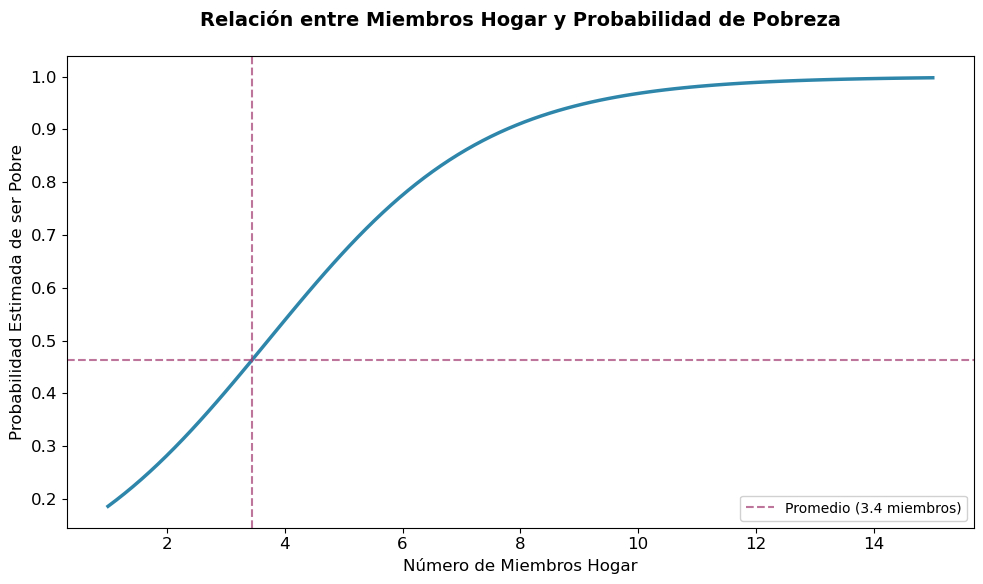

 Estadísticas del gráfico:
• Tamaño promedio del hogar: 3.4 miembros
• Probabilidad de pobreza en promedio: 0.463
• Efecto marginal: cada miembro adicional aumenta probabilidad en ~81.2%


In [63]:
print("\nB.2 VISUALIZACIÓN")
print("-"*40)

# Visualización de probabilidades - variable miembros_hogar
variable_visualizar = 'miembros_hogar'
valores_variable = np.linspace(X_train[variable_visualizar].min(), 
                              X_train[variable_visualizar].max(), 100)
probabilidades = []

for valor in valores_variable:
    fila_pred = X_train_const.mean().copy()
    fila_pred[variable_visualizar] = valor
    prob = logit_result.predict(fila_pred.values.reshape(1, -1))[0]
    probabilidades.append(prob)

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(valores_variable, probabilidades, linewidth=2.5, color='#2E86AB')  
plt.xlabel(f'Número de {variable_visualizar.replace("_", " ").title()}', fontsize=12)
plt.ylabel('Probabilidad Estimada de ser Pobre', fontsize=12)
plt.title(f'Relación entre {variable_visualizar.replace("_", " ").title()} y Probabilidad de Pobreza\n', 
          fontsize=14, fontweight='bold')

# Estadísticas del gráfico
promedio_hogar = X_train[variable_visualizar].mean()
prob_promedio = logit_result.predict(X_train_const.mean().values.reshape(1, -1))[0]
plt.axvline(x=promedio_hogar, color='#A23B72', linestyle='--', alpha=0.7, 
           label=f'Promedio ({promedio_hogar:.1f} miembros)')
plt.axhline(y=prob_promedio, color='#A23B72', linestyle='--', alpha=0.7)

plt.legend(fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

print(f" Estadísticas del gráfico:")
print(f"• Tamaño promedio del hogar: {promedio_hogar:.1f} miembros")
print(f"• Probabilidad de pobreza en promedio: {prob_promedio:.3f}")
print(f"• Efecto marginal: cada miembro adicional aumenta probabilidad en ~{(probabilidades[-1] - probabilidades[0])*100:.1f}%")

In [42]:
# =============================================================================
# C. MÉTODO DE KNN
# =============================================================================

In [43]:
# 1. Estimación con diferentes K

In [44]:
print("\n" + "="*70)
print("C. MÉTODO DE VECINOS CERCANOS (KNN)")
print("="*70)

print("\nC.1 ESTIMACIÓN CON DIFERENTES K")
print("-"*40)

# Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Estimación con diferentes K
k_values = [1, 5, 10]
knn_models = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_models[k] = knn
    train_accuracy = knn.score(X_train_scaled, y_train)
    print(f"K={k}: Precisión en entrenamiento = {train_accuracy:.3f}")

print("\n🔍 TRADE-OFF SESGO-VARIANZA:")
print("• K pequeño (ej. K=1): Alto ajuste (bajo sesgo) pero puede sobreajustar (alta varianza)")
print("• K grande (ej. K=10): Más generalización (baja varianza) pero puede perder patrones (alto sesgo)")
print("• K intermedio (ej. K=5): Balance entre capturar patrones y generalizar")


C. MÉTODO DE VECINOS CERCANOS (KNN)

C.1 ESTIMACIÓN CON DIFERENTES K
----------------------------------------
K=1: Precisión en entrenamiento = 0.895
K=5: Precisión en entrenamiento = 0.773
K=10: Precisión en entrenamiento = 0.754

🔍 TRADE-OFF SESGO-VARIANZA:
• K pequeño (ej. K=1): Alto ajuste (bajo sesgo) pero puede sobreajustar (alta varianza)
• K grande (ej. K=10): Más generalización (baja varianza) pero puede perder patrones (alto sesgo)
• K intermedio (ej. K=5): Balance entre capturar patrones y generalizar


In [45]:
# 2. Visualización con dos características


C.2 VISUALIZACIÓN CON DOS CARACTERÍSTICAS
----------------------------------------


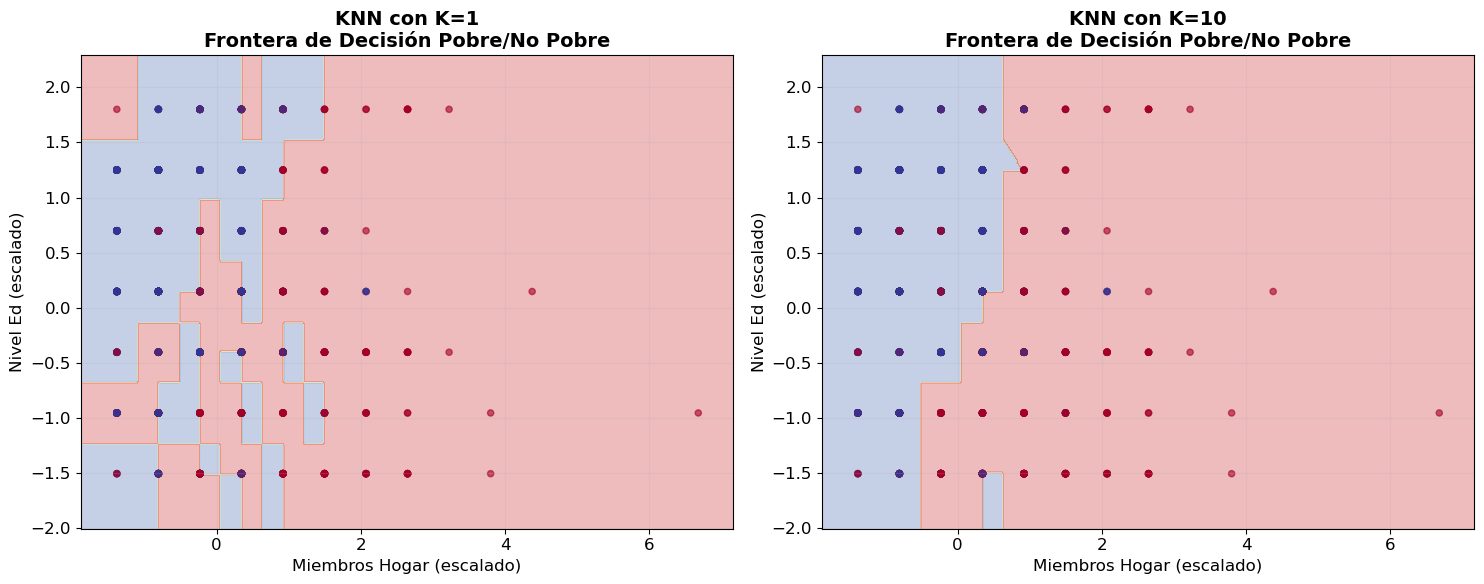

Características visualizadas:
• Eje X: miembros_hogar (escalado)
• Eje Y: nivel_ed (escalado)


In [46]:
print("\nC.2 VISUALIZACIÓN CON DOS CARACTERÍSTICAS")
print("-"*40)

# Seleccionar dos características numéricas importantes
caracteristica1 = 'miembros_hogar'
caracteristica2 = 'nivel_ed'

# Subconjunto para visualización
np.random.seed(444)
indices_visual = np.random.choice(len(X_train), min(1000, len(X_train)), replace=False)
X_visual = X_train.iloc[indices_visual][[caracteristica1, caracteristica2]]
y_visual = y_train.iloc[indices_visual]

# Escalar para visualización
scaler_visual = StandardScaler()
X_visual_scaled = scaler_visual.fit_transform(X_visual)

# Crear mesh para fronteras de decisión
x_min, x_max = X_visual_scaled[:, 0].min() - 0.5, X_visual_scaled[:, 0].max() + 0.5
y_min, y_max = X_visual_scaled[:, 1].min() - 0.5, X_visual_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, k in enumerate([1, 10]):
    knn_visual = KNeighborsClassifier(n_neighbors=k)
    knn_visual.fit(X_visual_scaled, y_visual)
    
    Z = knn_visual.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r')
    scatter = axes[idx].scatter(X_visual_scaled[:, 0], X_visual_scaled[:, 1], 
                              c=y_visual, cmap='RdYlBu_r', alpha=0.6, s=20)
    
    axes[idx].set_xlabel(f'{caracteristica1.replace("_", " ").title()} (escalado)', fontsize=12)
    axes[idx].set_ylabel(f'{caracteristica2.replace("_", " ").title()} (escalado)', fontsize=12)
    axes[idx].set_title(f'KNN con K={k}\nFrontera de Decisión Pobre/No Pobre', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.2, linestyle='-')

plt.tight_layout()
plt.show()

print(f"Características visualizadas:")
print(f"• Eje X: {caracteristica1} (escalado)")
print(f"• Eje Y: {caracteristica2} (escalado)")

In [47]:
# 3. K óptimo por Cross - Validation


C.3 K ÓPTIMO POR CROSS-VALIDATION
----------------------------------------
K óptimo: 19 (Precisión: 0.711)


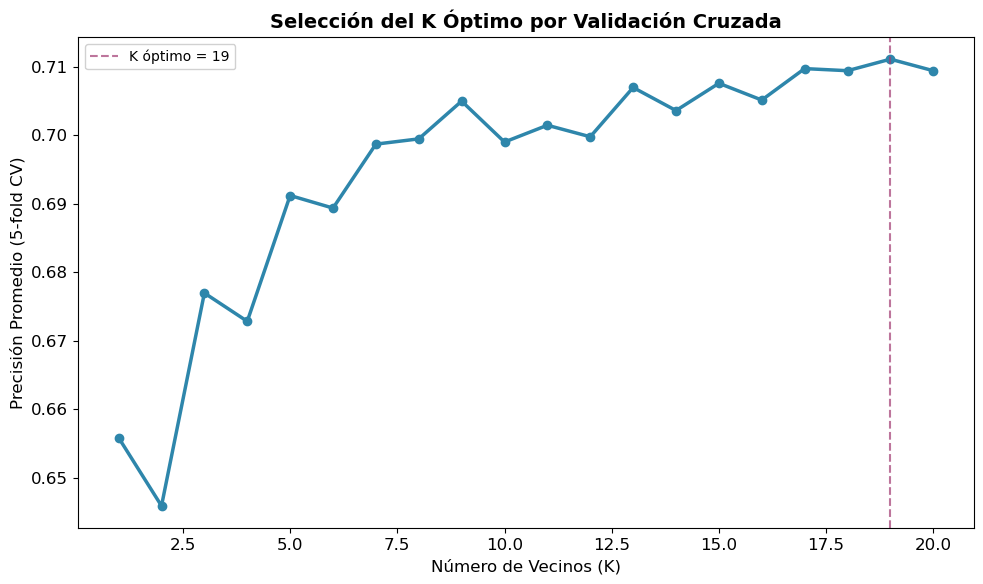


📊 RESUMEN KNN:
• K óptimo por CV: 19
• Precisión en CV: 0.711
• Precisión en entrenamiento: 0.745


In [61]:
print("\nC.3 K ÓPTIMO POR CROSS-VALIDATION")
print("-"*40)

# Probar diferentes valores de K
k_range = range(1, 21)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontrar el K óptimo
optimal_k = k_range[np.argmax(k_scores)]
optimal_score = max(k_scores)

print(f"K óptimo: {optimal_k} (Precisión: {optimal_score:.3f})")

# Gráfico de K vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o', linewidth=2.5, color='#2E86AB')
plt.axvline(x=optimal_k, color='#A23B72', linestyle='--', alpha=0.7, 
           label=f'K óptimo = {optimal_k}')
plt.xlabel('Número de Vecinos (K)', fontsize=12)
plt.ylabel('Precisión Promedio (5-fold CV)', fontsize=12)
plt.title('Selección del K Óptimo por Validación Cruzada', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

# Entrenar modelo final con K óptimo
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train_scaled, y_train)

print(f"\n📊 RESUMEN KNN:")
print(f"• K óptimo por CV: {optimal_k}")
print(f"• Precisión en CV: {optimal_score:.3f}")
print(f"• Precisión en entrenamiento: {knn_optimal.score(X_train_scaled, y_train):.3f}")

In [49]:
# =============================================================================
# D. DESEMPEÑO DE LOS MODELOS
# =============================================================================

In [50]:
# 1. Matriz de confusión logit

In [51]:
print("\n" + "="*70)
print("D. DESEMPEÑO DE MODELOS FUERA DE MUESTRA")
print("="*70)

print("\nD.1 MATRIZ DE CONFUSIÓN (LOGIT)")
print("-"*40)

# Predicciones de ambos modelos
y_pred_logit = (logit_result.predict(X_test_const) > 0.5).astype(int)
y_prob_logit = logit_result.predict(X_test_const)
y_pred_knn = knn_optimal.predict(X_test_scaled)
y_prob_knn = knn_optimal.predict_proba(X_test_scaled)[:, 1]

# Matriz de confusión para Logit
cm_logit = confusion_matrix(y_test, y_pred_logit)
cm_df_logit = pd.DataFrame(cm_logit, 
                          index=['Real No Pobre', 'Real Pobre'],
                          columns=['Pred No Pobre', 'Pred Pobre'])

print("Matriz de Confusión - Regresión Logística:")
display(cm_df_logit)

# Métricas de la matriz de confusión
tn, fp, fn, tp = cm_logit.ravel()
sensibilidad_logit = tp / (tp + fn)
especificidad_logit = tn / (tn + fp)
precision_logit = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"Sensibilidad (Pobre): {sensibilidad_logit:.3f}")
print(f"Especificidad (No Pobre): {especificidad_logit:.3f}")
print(f"Precisión (Pobre): {precision_logit:.3f}")


D. DESEMPEÑO DE MODELOS FUERA DE MUESTRA

D.1 MATRIZ DE CONFUSIÓN (LOGIT)
----------------------------------------
Matriz de Confusión - Regresión Logística:


,Pred No Pobre,Pred Pobre
Real No Pobre,1134,372
Real Pobre,499,797


Sensibilidad (Pobre): 0.615
Especificidad (No Pobre): 0.753
Precisión (Pobre): 0.682


In [52]:
# 2. Curva ROC


D.2 CURVA ROC
----------------------------------------


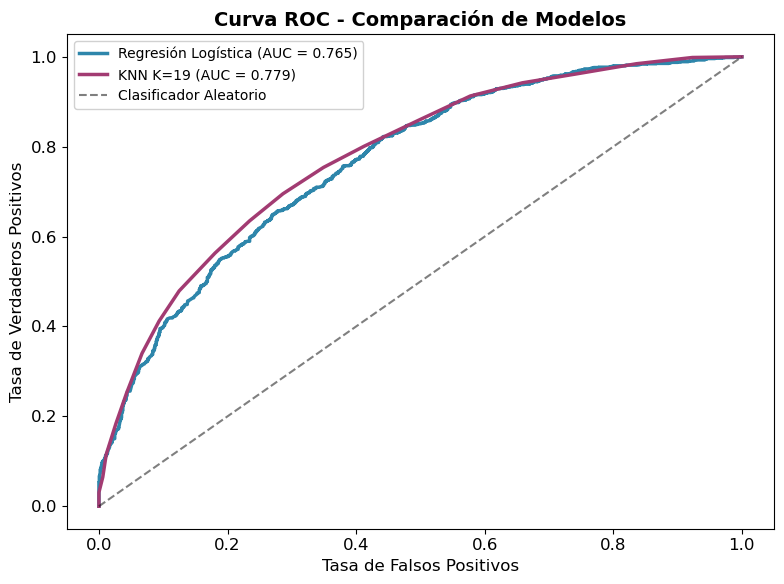

In [64]:
print("\nD.2 CURVA ROC")
print("-"*40)

# Calcular curvas ROC
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_prob_logit)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

# Calcular AUC
auc_logit = auc(fpr_logit, tpr_logit)
auc_knn = auc(fpr_knn, tpr_knn)

# Gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_logit, tpr_logit, label=f'Regresión Logística (AUC = {auc_logit:.3f})', 
         linewidth=2.5, color='#2E86AB')
plt.plot(fpr_knn, tpr_knn, label=f'KNN K={optimal_k} (AUC = {auc_knn:.3f})', 
         linewidth=2.5, color='#A23B72')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curva ROC - Comparación de Modelos', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

In [54]:
# 3. Métricas de clasificación

In [55]:
print("\nD.3 MÉTRICAS DE CLASIFICACIÓN")
print("-"*40)

metricas = {
    'Accuracy': accuracy_score,
    'Precision (Pobre)': lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=1),
    'Recall/Sensibilidad (Pobre)': lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1),
    'F1-Score (Pobre)': lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1)
}

resultados = pd.DataFrame(index=metricas.keys(), columns=['Logit', 'KNN'])

for metrica, funcion in metricas.items():
    resultados.loc[metrica, 'Logit'] = funcion(y_test, y_pred_logit)
    resultados.loc[metrica, 'KNN'] = funcion(y_test, y_pred_knn)

display(resultados.round(3))


D.3 MÉTRICAS DE CLASIFICACIÓN
----------------------------------------


,Logit,KNN
Accuracy,0.689151,0.705211
Precision (Pobre),0.681779,0.69983
Recall/Sensibilidad (Pobre),0.614969,0.635031
F1-Score (Pobre),0.646653,0.665858


In [56]:
# 4. Análisis de políticas píublicas

In [57]:
print("\nD.4 ANÁLISIS PARA POLÍTICAS PÚBLICAS")
print("-"*40)

print("🔍 CONTEXTO: Ministerio de Capital Humano - Programa de Alimentos")
print("OBJETIVO: Identificar grupos vulnerables para asignar recursos escasos")

sensibilidad_knn = recall_score(y_test, y_pred_knn, pos_label=1)
especificidad_knn = recall_score(y_test, y_pred_knn, pos_label=0)

print(f"\nCOMPARACIÓN DE MODELOS:")
print(f"• REGRESIÓN LOGÍSTICA:")
print(f"  - Sensibilidad (detecta pobres): {sensibilidad_logit:.1%}")
print(f"  - Especificidad (evita falsos pobres): {especificidad_logit:.1%}")
print(f"  - AUC: {auc_logit:.3f}")

print(f"• KNN (K={optimal_k}):")
print(f"  - Sensibilidad (detecta pobres): {sensibilidad_knn:.1%}")
print(f"  - Especificidad (evita falsos pobres): {especificidad_knn:.1%}")
print(f"  - AUC: {auc_knn:.3f}")

# Recomendación
print(f"\n RECOMENDACIÓN:")
if sensibilidad_logit > sensibilidad_knn:
    print("• MODELO RECOMENDADO: REGRESIÓN LOGÍSTICA")
    modelo_elegido = 'logit'
else:
    print("• MODELO RECOMENDADO: KNN")
    modelo_elegido = 'knn'

print("\n JUSTIFICACIÓN:")
print("En programas sociales, es preferible ERRAR POR EXCESO (incluir algunos no pobres)")
print("que ERRAR POR DEFECTO (dejar pobres sin ayuda). Por lo tanto, priorizamos SENSIBILIDAD.")


D.4 ANÁLISIS PARA POLÍTICAS PÚBLICAS
----------------------------------------
🔍 CONTEXTO: Ministerio de Capital Humano - Programa de Alimentos
OBJETIVO: Identificar grupos vulnerables para asignar recursos escasos

COMPARACIÓN DE MODELOS:
• REGRESIÓN LOGÍSTICA:
  - Sensibilidad (detecta pobres): 61.5%
  - Especificidad (evita falsos pobres): 75.3%
  - AUC: 0.765
• KNN (K=19):
  - Sensibilidad (detecta pobres): 63.5%
  - Especificidad (evita falsos pobres): 76.6%
  - AUC: 0.779

 RECOMENDACIÓN:
• MODELO RECOMENDADO: KNN

 JUSTIFICACIÓN:
En programas sociales, es preferible ERRAR POR EXCESO (incluir algunos no pobres)
que ERRAR POR DEFECTO (dejar pobres sin ayuda). Por lo tanto, priorizamos SENSIBILIDAD.


In [58]:
# 5. Predicción en base no respondieron

In [59]:
print("\nD.5 PREDICCIÓN EN BASE NO-RESPONDIERON")
print("-"*40)

# Preparar datos de norespondieron_2025
X_noresp = norespondieron_2025[variables_x].copy()
X_noresp_scaled = scaler.transform(X_noresp)

# Predecir con el modelo KNN seleccionado
y_pred_noresp = knn_optimal.predict(X_noresp_scaled)
y_prob_noresp = knn_optimal.predict_proba(X_noresp_scaled)[:, 1]

# Resultados
pobreza_predicha_noresp = pd.Series(y_pred_noresp, index=X_noresp.index)
tasa_pobreza_predicha = pobreza_predicha_noresp.mean()
num_pobres_predichos = pobreza_predicha_noresp.sum()

print(f" RESULTADOS PREDICCIÓN NO-RESPONDIERON:")
print(f"• Total personas en norespondieron_2025: {len(norespondieron_2025):,}")
print(f"• Personas identificadas como pobres: {num_pobres_predichos:,}")
print(f"• Tasa de pobreza predicha: {tasa_pobreza_predicha:.1%}")
print(f"• Tasa de pobreza en respondieron (real): {y_test.mean():.1%}")

# Guardar resultados
norespondieron_2025_con_pred = norespondieron_2025.copy()
norespondieron_2025_con_pred['pobre_predicho'] = pobreza_predicha_noresp
norespondieron_2025_con_pred['prob_pobreza'] = y_prob_noresp




D.5 PREDICCIÓN EN BASE NO-RESPONDIERON
----------------------------------------
 RESULTADOS PREDICCIÓN NO-RESPONDIERON:
• Total personas en norespondieron_2025: 4,463
• Personas identificadas como pobres: 1,836
• Tasa de pobreza predicha: 41.1%
• Tasa de pobreza en respondieron (real): 46.3%


In [66]:
# =============================================================================
# FIN DEL TRABAJO PRÁCTICO
# =============================================================================